In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import sqlalchemy_access
from quetzal.model import stepmodel
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme import expressions as ex


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
input_path = '../input/'
output_path = '../outputs/'
model_path = '../model/'

# Calibrate the demand models

## Load data

Use survey data from: „Mobilität in Städten – SrV 2018“, Stichprobe Berlin, Senatsverwaltung für Mobilität, Verkehr, Klimaschutz und Umwelt Berlin, Abtei-lung Mobilität

In [3]:
# Establish an SQL connection to data base
def get_connection(file_name):
    connection_string = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        r"DBQ="+input_path+'transport_demand/SrV2018_B_Access/'+file_name+";"
    )
    connection_url = sa.engine.URL.create(
        "access+pyodbc",
        query={"odbc_connect": connection_string},
    )
    engine = sa.create_engine(connection_url)
    return engine

In [4]:
# Load data
engine = get_connection("SrV2018_Einzeldaten_Berlin_SciUse.accdb")
trip_cols = ['HHNR', 'PNR', 'WNR', 'GEWICHT_W', 'E_RVA', # general
             'V_START_LAGE', 'V_START_PLZ', 'V_ZIEL_LAGE', 'V_ZIEL_PLZ', # origin, destination
             'V_LAENGE', 'GIS_LAENGE', 'E_DAUER', 'E_GESCHW', # length, duration
             'V_ZWECK', 'V_BEGLEITUNG_OHNE', 'E_QZG_17', # purpose
             'V_UMSTIEG_ANZAHL', 'V_F_ANZAHL', # trip characteristics
             'V_VM_LAENG', 'E_HVM', 'E_HVM_4' # mode
            ]# + ['V_VM_REIHE_'+str(i) for i in range(1,9)]
trips = pd.read_sql_query(sql=sa.text("select " + ", ".join(trip_cols) + " from W2018"), con=engine.connect())
persons_cols = ['HHNR', 'PNR', 'GEWICHT_P', 'E_ERW_3', 'E_ZUGANG_PKW',
                'E_MOBIL2', 'E_ANZ_WEGE2', 
                'E_OEV_FK']
persons = pd.read_sql_query(sql=sa.text("select " + ", ".join(persons_cols) + " from P2018"), con=engine.connect())
codes = pd.read_sql_query(sql=sa.text("select * from tblDatenkodierung"), con=engine.connect())

In [5]:
# Number of trips by type
trips['E_RVA'].map(codes.loc[codes['Variable']=='E_RVA'].set_index('Kodierungsnr')['Kodierungstext']).value_counts()

Binnenverkehr               123917
Quellverkehr                  3131
Zielverkehr                   3048
Außenverkehr                  1122
Berechnung nicht möglich        16
Name: E_RVA, dtype: int64

In [6]:
# Filter
trips = trips.loc[(trips['E_RVA']==1) # within Berlin
                  & (trips['E_DAUER']!=-7) # reasonable duration
                  & (trips['V_LAENGE']>1) # reasonable distance
                  & (trips['V_LAENGE']<50) # reasonable distance
                  & (trips['E_QZG_17']!=-7) # reasonable purpose
                  & (trips['E_HVM_4']!=-7) # reasonable mode
                 ]
len(trips)

76340

<AxesSubplot:>

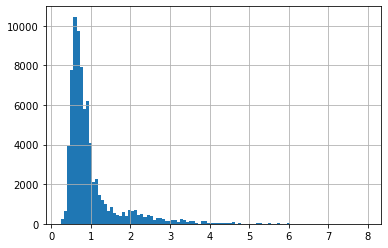

In [7]:
# trips weight distribution for population representation
trips['GEWICHT_W'].hist(bins=100)

In [8]:
# Merge person information with trips
trips['ID'] = trips['HHNR'].astype(str) + '_' + trips['PNR'].astype(str)
persons['ID'] = persons['HHNR'].astype(str) + '_' + persons['PNR'].astype(str)
persons.drop(columns=['HHNR', 'PNR'], inplace=True)
trips = trips.merge(persons, on='ID', how='left')

In [9]:
# Create mode categories
trips['mode'] = trips['E_HVM_4'] # 1: walk, 2: bicycle, 3: MIT, 4: PT
trips.loc[trips['E_HVM']==16, 'mode'] = 5 # Taxi
trips.loc[trips['E_HVM'].isin([5,8]), 'mode'] = 6 # Car sharing

In [10]:
# Filter for reasonable speeds
mode_max_speeds = {1: 15, 2: 30, 3: 80, 4: 80, 5: 80, 6: 80} #km/h
trips = trips.loc[trips['E_GESCHW']>1]
for mode, speed in mode_max_speeds.items():
    trips = trips.loc[~((trips['mode']==mode) & (trips['E_GESCHW']>speed))]
len(trips)

76150

In [11]:
# Filter for reasonable duration
trips = trips.loc[trips['E_DAUER']<200]
len(trips)

76132

In [12]:
# Drop observations that used private cars without car availability
trips = trips.loc[~((trips['E_ZUGANG_PKW']==0) & (trips['mode']==3))]
trips = trips.loc[trips['E_ZUGANG_PKW']!=-7]
len(trips)

71736

In [13]:
# Number of observations by mode
trips.groupby('mode').count()['GEWICHT_W']

mode
1     7644
2    16314
3    23791
4    23552
5      264
6      171
Name: GEWICHT_W, dtype: int64

In [14]:
inf = 999999

## Mode choice

Calibrate a mode choice model

### Data preparation

Add level of service attributes

In [41]:
# Add price attributes based on mode-specific assumptions
# See assumptions in 05_Simulation

# non-motorised
trips['price_walk'] = 0
trips['price_bicycle'] = 0

# Motorised individual traffic
trips['price_car'] = trips['V_LAENGE'] * 0.14 # EUR/km
trips['price_taxi'] = trips['V_LAENGE'] * 2.3 + 4
trips['price_car_sharing'] = trips['E_DAUER'] * 0.15 # EUR/min
#trips['V_LAENGE'] * 1 / 1000, # Miles (EUR/km)

# Public transport
trips['price_pt'] = trips['E_OEV_FK'].map(
    {1: 3.5, 2: 10/5, 3: 49/30/4,
     60:0, 70:0, -8:3.5, -10:3.5})

In [16]:
# Load LoS table from model for travel times
sm = stepmodel.read_zippedpickles(model_path + 'los')

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.49s/it]


In [83]:
# Assign times of modes not chosen
# Use travel time means per distance class for each mode
# because the survey does not contain explicit origins and destinations
bins = [0, 1, 2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50, 60, 75]
labels = [i for i in bins[1:]]
sm.los = pd.concat([sm.pt_los, sm.car_los])
sm.los.loc[sm.los['all_walk']==True, 'length'] = sm.los.loc[sm.los['all_walk']==True, 'time'] * 5 / 3.6
sm.los = sm.los.loc[sm.los['length']>0]
sm.los.loc[sm.los['route_type']=='car', 'time'] += 2*3*60 # add parking time
sm.los.loc[sm.los['route_type'].isin(['bus', 'subway', 'tram', 'rail']), 'time'] += \
    sm.los.loc[sm.los['route_type'].isin(['bus', 'subway', 'tram', 'rail']), 'ntransfers'] * 2*60 # add transfer time
sm.los['bin'] = pd.cut(sm.los['length']/1000, bins, labels=labels)
sm.los['time'] = (sm.los['time'] / 60).astype(int)
sm.los['route_type'].replace(
    {'bike': 'bicycle', 'bus': 'pt', 'rail': 'pt', 'subway': 'pt', 'tram': 'pt'}, inplace=True)

In [84]:
# Number of OD pairs per distance bin by mode
sm.los.groupby(['bin', 'route_type']).count()['origin'].unstack()

route_type,bicycle,car,pt,walk
bin,,,,
1,383,383,623,119
2,1902,1902,1688,18
3,3147,3147,2502,1
5,9759,9759,7033,0
7,13156,13156,8318,0
10,24469,24469,14887,0
13,28294,28294,16424,0
16,28791,28791,18294,0
20,32938,32938,25759,0


<AxesSubplot:xlabel='bin'>

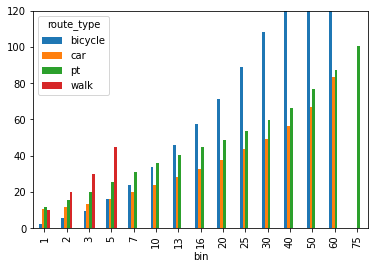

In [94]:
# Time distribution by mode
time_mode_dist = sm.los.groupby(['bin', 'route_type']).mean()['time'].unstack()
time_mode_dist['walk'] = [10, 20, 30, 45] + [np.nan for _ in range(len(time_mode_dist)-4)]
time_mode_dist.plot.bar(ylim=(0,120))

<AxesSubplot:xlabel='bin'>

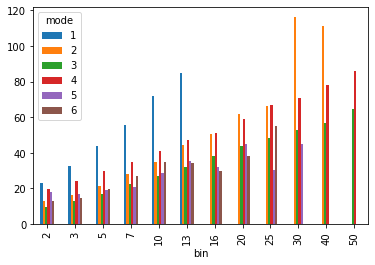

In [95]:
# In survey data
trips['bin'] = pd.cut(trips['V_LAENGE'], bins, labels=labels).astype(int)
trips.groupby(['bin', 'mode']).mean()['E_DAUER'].unstack().plot.bar()

In [112]:
# Add time to calibration data
mode_dict = {1: 'walk', 2: 'bicycle', 3: 'car', 4: 'pt', 5: 'taxi', 6: 'car_sharing'}
time_mode_dist.index = time_mode_dist.index.astype(int)
for i, mode in mode_dict.items():
    trips['time_'+mode] = np.nan
    mask = trips['mode']==i
    # Observed time for the chosen mode
    trips.loc[mask, 'time_'+mode] = trips.loc[mask, 'E_DAUER']
    # Synthetic times for other modes
    model_mode = mode if mode in time_mode_dist.columns else 'car'
    trips.loc[~(mask), 'time_'+mode] = trips.loc[~(mask), 'bin'].map(time_mode_dist[model_mode])
    # Perform cost damping
    #trips['time_'+mode] = np.power(np.log(trips['time_'+mode]), 3)
    trips['time_'+mode] /= 60
    # Replace NaN with infinity
    trips['time_'+mode].fillna(inf, inplace=True)

In [113]:
# Generate availability columns based on time
for mode in mode_dict.values():
    trips['av_'+mode] = (trips['time_'+mode] != inf).astype(int)

### Model formulation

Use biogeme notation. Split population by car availability and PT subscription.

In [114]:
# make database columns global variables
price_cols = [c for c in trips.columns if 'price' in c]
time_cols = [c for c in trips.columns if 'time' in c]
av_cols = [c for c in trips.columns if 'av_' in c]
db_all = db.Database('all_trips', trips[['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
globals().update(db_all.variables)

In [115]:
# Estimation parameters
# ASC
asc_walk = ex.Beta('asc_walk', 0, None, None, 0)
asc_bicycle = ex.Beta('asc_bicycle', 0, None, None, 0)
asc_car = ex.Beta('asc_car', 0, None, None, 0)
asc_pt = ex.Beta('asc_pt', 0, None, None, 1)
asc_taxi = ex.Beta('asc_taxi', 0, None, None, 0)
asc_car_sharing = ex.Beta('asc_car_sharing', 0, None, None, 0)
# Beta
b_t = ex.Beta('b_t', 0, None, 0, 0)
b_p = ex.Beta('b_p', 0, None, 0, 0)

In [116]:
# Utility functions
V_walk = asc_walk + b_t * time_walk + b_p * price_walk
V_bicycle = asc_bicycle + b_t * time_bicycle + b_p * price_bicycle
V_car = asc_car + b_t * time_car + b_p * price_car
V_pt = asc_pt + b_t * time_pt + b_p * price_pt
V_taxi = asc_taxi + b_t * time_taxi + b_p * price_taxi
V_car_sharing = asc_car_sharing + b_t * time_car_sharing + b_p * price_car_sharing
V = {1: V_walk,
     2: V_bicycle,
     3: V_car,
     4: V_pt,
     5: V_taxi,
     6: V_car_sharing}

In [117]:
# Availability formulation
A = {1: av_walk,
     2: av_bicycle,
     3: av_car,
     4: av_pt,
     5: av_taxi,
     6: av_car_sharing}

### Estimation

In [118]:
# Estimation
results = []
def estimate(database, writer, name):
    print('Sample size for {}: {}'.format(name, database.getSampleSize()))
    mnl = models.loglogit(V, A, mode) # Choose utility functions and availabilities
    formulas = {'loglike': mnl, 'weight': GEWICHT_W} # give weights to the estimator
    model = bio.BIOGEME(database, formulas)
    model.generateHtml = False
    model.generatePickle = False
    model.saveIterations = False
    model.modelName = name
    results.append(model.estimate()) # Estimation
    output = results[-1].getEstimatedParameters()
    # Add results to the Excel file
    for key, val in results[-1].getGeneralStatistics().items():
        output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
    output.to_excel(writer, sheet_name=model.modelName)

In [119]:
writer = pd.ExcelWriter(input_path + 'mode_choice_estimation.xls', engine='xlsxwriter')
# with car without PT abo
name = 'car_no_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==-1) & ~(trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# No car, no PT abo
name = 'no_car_no_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==0) & ~(trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# with car and pt abo
name = 'car_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==-1) & (trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# No car and pt abo
name = 'no_car_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==0) & (trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)

# Save results
writer.save()

Sample size for car_no_pt_abo: 29624
Sample size for no_car_no_pt_abo: 7814
Sample size for car_pt_abo: 15700
Sample size for no_car_pt_abo: 18598
